# Классификация текстов


## Бинарная классификация (эмоциональная окраска отзывов на IMDB)

In [57]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import losses

### Скачайте датасет

In [58]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [59]:
os.listdir(dataset_dir)

['test', 'train']

In [60]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [61]:
sample_file = os.path.join(train_dir, 'java/2.txt')
with open(sample_file) as f:
  print(f.read())

"identifier required when invoking a private method i am calling a private method for testing and for that i am using the following code to invoke private method. repeat() is the private method of class diamond..import org.junit.test;.import static org.junit.assert.*;.import blank.lang.stringbuilder;.import blank.lang.reflect.method;.public class diamondunit {.        stringbuilder expect = new stringbuilder();.        diamond test = new diamond();.        method m = test.getclass().getdeclaredmethod(""repeat"");.        m.setaccessible(true);.        m.invoke(test);..    @test.        public void testrepeatneg() {.            assertequals("""", test.repeat(expect,""a"",-1));.        }.}...while compiling it is giving error ..diamondunit.blank:11: error: expected.m.setaccessible(true);.^.diamondunit.blank:11: error: illegal start of type.m.setaccessible(true);.^.diamondunit.blank:12: error: expected.m.invoke(test);.^.diamondunit.blank:12: error: expected.m.invoke(test);.^...i had cop p

### Загрузите датасет



In [62]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [63]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [64]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [65]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [66]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Подготовьте датасет

In [67]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [68]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [69]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [70]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [71]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [72]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [73]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Немного о вопросах производительности


In [74]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Создайте объект модели


In [75]:
embedding_dim = 16

In [76]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)]) # 4 класса

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

### Функция потерь и метод оптимизации


In [77]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Обучите модель


In [78]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


200/200 [==============================] - 6s 25ms/step - loss: 1.3783 - accuracy: 0.3280 - val_loss: 1.3665 - val_accuracy: 0.5013
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3487 - accuracy: 0.4634 - val_loss: 1.3267 - val_accuracy: 0.5256
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2983 - accuracy: 0.5289 - val_loss: 1.2673 - val_accuracy: 0.5788
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2293 - accuracy: 0.5758 - val_loss: 1.1956 - val_accuracy: 0.6162
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1567 - accuracy: 0.6184 - val_loss: 1.1224 - val_accuracy: 0.6575
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0795 - accuracy: 0.6594 - val_loss: 1.0521 - val_accuracy: 0.6837
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0087 - accuracy: 0.6888 - val_loss: 0.9882 - val_accuracy: 0.7069
Epoch 8/10
200/2

### Оцените качество модели


In [79]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 5s 21ms/step - loss: 0.8717 - accuracy: 0.7293
Loss:  0.8716959357261658
Accuracy:  0.7292500138282776


### Постройте графики точности и потерь по времени


In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

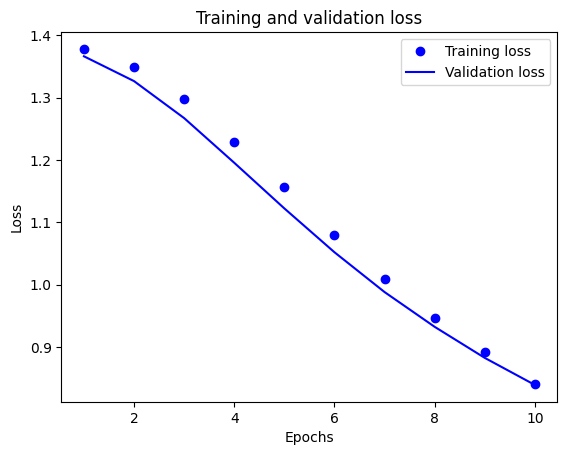

In [82]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

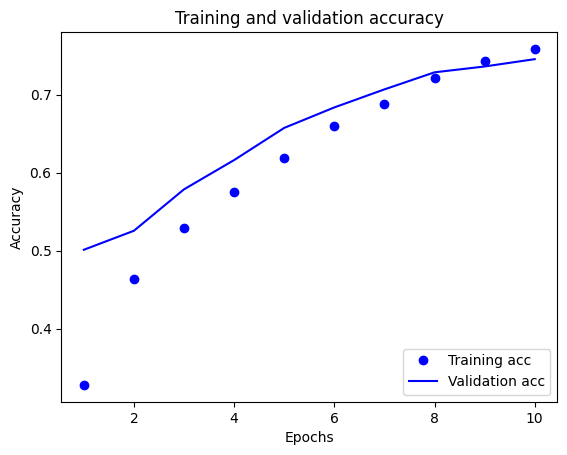

In [83]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Экспортируйте модель с дополнительным слоем подготовки данных


In [86]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 0.8717 - accuracy: 0.7293
0.7292500138282776


### Осуществите предсказание на новых для модели данных


In [91]:
examples = [
  "Furthermore, Java has a strong community support and a vast number of resources available online, including documentation, tutorials, and forums. ",
  "Moreover, JavaScript has a simple syntax that is easy to learn and understand.",
  "JavaScript offers a wide range of functionality, including manipulating HTML elements, handling events, and making asynchronous requests to servers. It also has a large number"
]

export_model.predict(examples)

1/1 [==============================] - 0s 63ms/step


array([[0.50230324, 0.45073766, 0.5352159 , 0.48551166],
       [0.5071833 , 0.4537482 , 0.5405059 , 0.4707041 ],
       [0.4992269 , 0.43284273, 0.5639756 , 0.48072016]], dtype=float32)